14.664594309799792


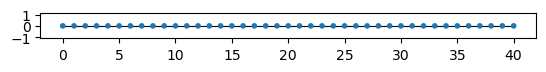

C:\Users\chenx\AppData\Local\Temp\ipykernel_21636\2165907775.py:101: KwantDeprecationWarning: The 'args' parameter has been deprecated since version 1.4 -- Instead, provide named parameters as a dictionary via 'params'.
  H = sys.hamiltonian_submatrix(args=[params], sparse=True)


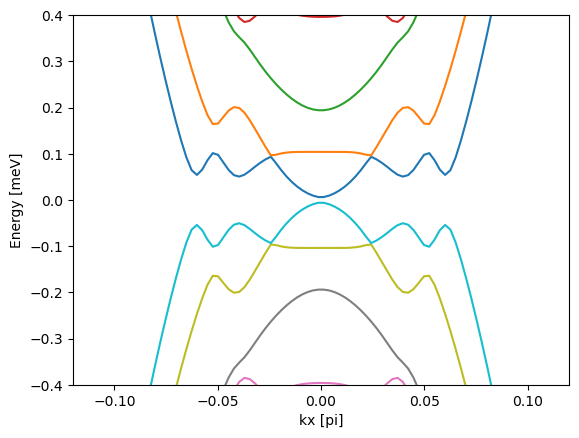

In [5]:
### Train program ###
### original file from Zeeman team ###
### Modified by X. Chen ###

from matplotlib import pyplot 
from pyx import *
import numpy 
import kwant 
import tinyarray
import scipy.sparse.linalg
import math 
import cmath 


# Python >= 3.3 provides SimpleNamespace in the standard library so we can 
# simply import it: 
# >>> from types import SimpleNamespace
# (Kwant already support Python 3) 

class SimpleNamespace(object):
    """A simple container for parameters."""
    def __init__(self, **kwargs):
        self.__dict__.update(kwargs)

def interact(function, **params):
    """A convenience function for varying parameters."""
    params_spec = {
        key: ipywidgets.FloatText(value=value, step=0.05)
        for key, value in params.items()
    }
    return ipywidgets.interactive(function, **params_spec) 

s_0 = numpy.identity(2) # 2-D identity matrix
s_z = numpy.array([[1,0],[0,-1]]) # Pauli matrix sigma_z
s_x = numpy.array([[0,1],[1,0]]) # Pauli matrix sigma_x 
s_y = numpy.array([[0,-1j],[1j,0]]) # Pauli matrix sigma_y 

### tau first, spin last ###
tau_zsigma_0 = tinyarray.array(numpy.kron(s_z,s_0))
tau_xsigma_0 = tinyarray.array(numpy.kron(s_x,s_0))
tau_ysigma_0 = tinyarray.array(numpy.kron(s_y,s_0))
tau_0sigma_z = tinyarray.array(numpy.kron(s_0,s_z))
tau_0sigma_x = tinyarray.array(numpy.kron(s_0,s_x))
tau_0sigma_y = tinyarray.array(numpy.kron(s_0,s_y))
tau_zsigma_x = tinyarray.array(numpy.kron(s_z,s_x))
tau_zsigma_y = tinyarray.array(numpy.kron(s_z,s_y))
tau_zsigma_z = tinyarray.array(numpy.kron(s_z,s_z))

tau_plus = (tau_xsigma_0 + 1j*tau_ysigma_0)/2 
tau_minus = (tau_xsigma_0 - 1j*tau_ysigma_0)/2 

a0 = 10 # 
Ly0 = 41 # 
Lys0 = 17 # 
Lyn0 = 24 # 

c = 3*math.pow(10,17)
hbar = 6.58*math.pow(10,-16)*1000 
me = 511000/(c*c)*1000
m = 0.026*me 
t0 = hbar*hbar/(2*m*a0*a0)
alpha = 10 
alphaR0 = alpha/(2*a0) 
print(t0)

def onsites1(site, p, a=a0):    
    return tau_zsigma_0 * (4 * p.t - (p.mu + 2 * p.t * math.cos(p.kx * a))) + tau_0sigma_x * p.Ez +\
              2 * p.alphaR * math.sin(p.kx * a) * tau_zsigma_y +\
              tau_plus * p.Delta * cmath.exp(1j*p.phase1*3.1415926) +\
              tau_minus * p.Delta * cmath.exp(-1j*p.phase1*3.1415926)

def onsites2(site, p, a=a0):
    return tau_zsigma_0 * (4 * p.t - (p.mu + 2 * p.t * math.cos(p.kx * a))) + tau_0sigma_x * p.Ez +\
              2 * p.alphaR * math.sin(p.kx * a) * tau_zsigma_y +\
              tau_plus * p.Delta * cmath.exp(1j*p.phase2*3.1415926) +\
              tau_minus * p.Delta * cmath.exp(-1j*p.phase2*3.1415926)

def onsiten(site, p, a=a0):
    return tau_zsigma_0 * (4 * p.t - (p.mu + 2 * p.t * math.cos(p.kx * a))) + tau_0sigma_x * p.Ez +\
              2 * p.alphaR * math.sin(p.kx * a) * tau_zsigma_y
                
def hopping(site0, site1, p, a=a0):
    return -tau_zsigma_0 * p.t - 1j * p.alphaR * tau_zsigma_x 

def make_system(a=a0,Lys=Lys0,Lyn=Lyn0,Ly=Ly0):
    sys = kwant.Builder()
    lat = kwant.lattice.chain() 

    sys[(lat(x) for x in range(0,Lys))] = onsites1
    sys[(lat(x) for x in range(Lys,Lyn))] = onsiten 
    sys[(lat(x) for x in range(Lyn,Ly))] = onsites2

    sys[lat.neighbors()] = hopping 
    return sys 

def plot_MBSspectrum(sys):    
    kx_values = numpy.linspace(-0.12, 0.12, 300)
    energies = []
    params = SimpleNamespace(t=t0, mu=0.3, alphaR=0.5, Delta=0.15, Ez=0.25, phase1=0, phase2=0)
    for params.kx in kx_values:
        H = sys.hamiltonian_submatrix(args=[params], sparse=True)
        H = H.tocsc()
        eigs = scipy.sparse.linalg.eigsh(H, k=40, sigma=0)
        energies.append(numpy.sort(eigs[0]))

    pyplot.plot(kx_values*10/3.1415926, energies)
    pyplot.xlabel("kx [pi]")
    pyplot.ylabel("Energy [meV]")
    pyplot.axis([-0.12, 0.12, -0.4, 0.4])
    pyplot.show()

    kx_E = numpy.transpose(numpy.vstack((kx_values, numpy.transpose(energies))))
    numpy.savetxt("kx_E.txt", kx_E)
    

def main():
    # Build a system
    sys = make_system()

    # Check that the system looks as intended.
    kwant.plot(sys)

    # Finalize the system.
    sys = sys.finalized()

    # calculate and Plot
    plot_MBSspectrum(sys)
    #write_wave_function(sys, Lx=Lx0, Ly=Ly0, a=a0)
    
if __name__ == '__main__':
    main()
 

